# Starting with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

In [1]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible
tf.config.list_physical_devices('GPU')

digits = datasets.load_digits()
# NORMALIZATION, SO IMPORTANT
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

X = X.reshape((X.shape[0],8,8,1)) # reshape as images

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(1437, 8, 8, 1)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

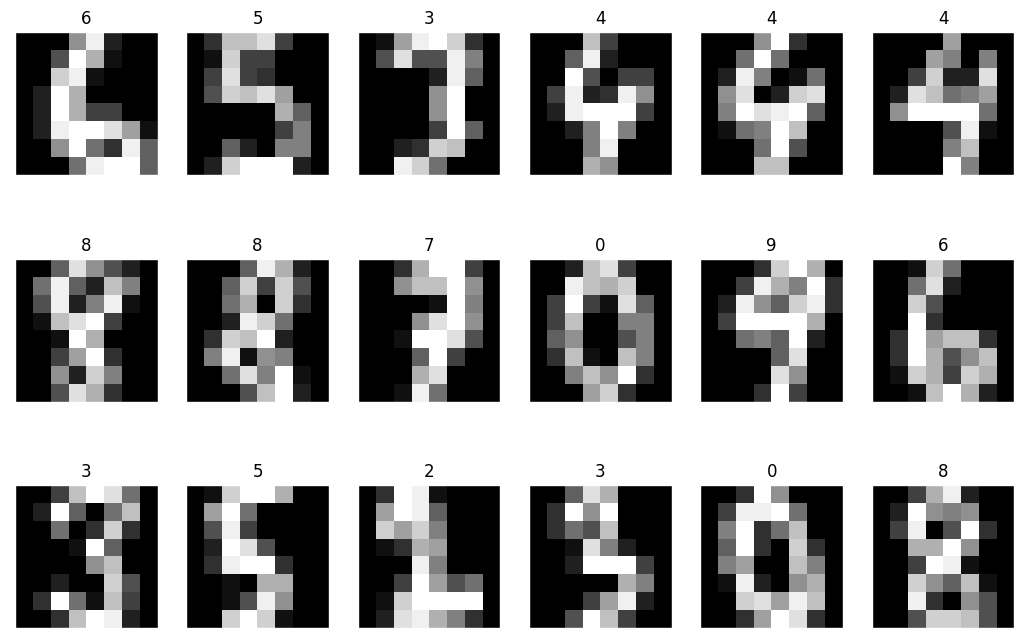

In [3]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images



____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
Wouldn't it be great if we did not need to specify the correct filters (like in DAISY)? What if we could just let the weights of the convolution be found through neural network training methods. Of course, we can! Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

**BONUS**: Let's start using the sequential API, rather than the funcitonal API

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.9.0'

In [5]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 8, 8, 1)
(360, 8, 8, 1)


In [6]:
%%time

# since this is not binary, we should go ahead and one-hot encode the inputs
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

2023-01-12 23:57:01.758432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 23:57:02.573330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 6.0


CPU times: user 21.8 s, sys: 1.69 s, total: 23.5 s
Wall time: 23.6 s


In [7]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(8,8,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 16)          80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 activation_1 (Activation)   (None, 4, 4, 16)          0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                      

In [8]:
%%time 

print(X_train.shape)
# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1437, 8, 8, 1)


2023-01-12 23:57:26.708133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


CPU times: user 24.3 s, sys: 1.47 s, total: 25.7 s
Wall time: 26 s


In [9]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

12/12 [==============================] - 0s 2ms/step


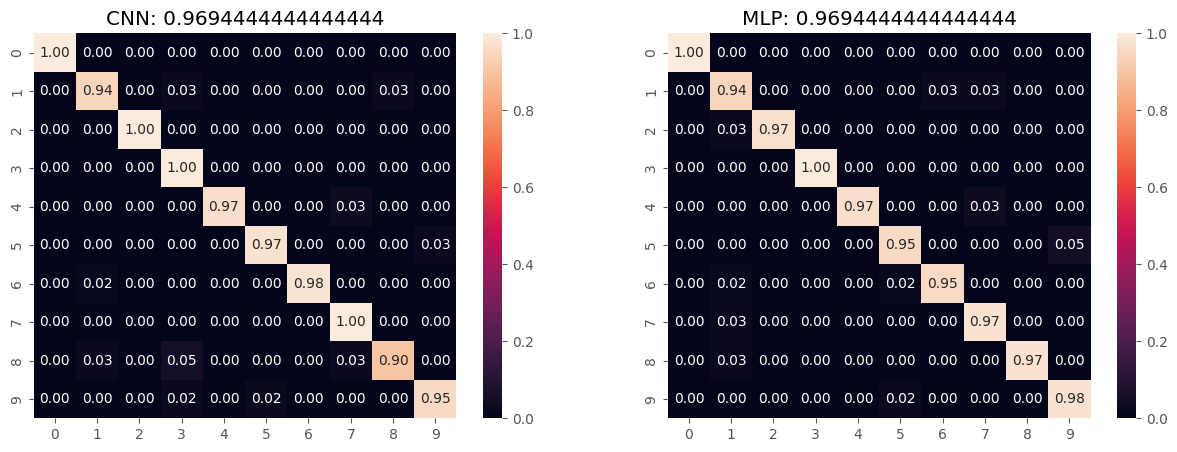

In [11]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

12/12 [==============================] - 0s 2ms/step
CPU times: user 24 s, sys: 1.14 s, total: 25.2 s
Wall time: 25.3 s


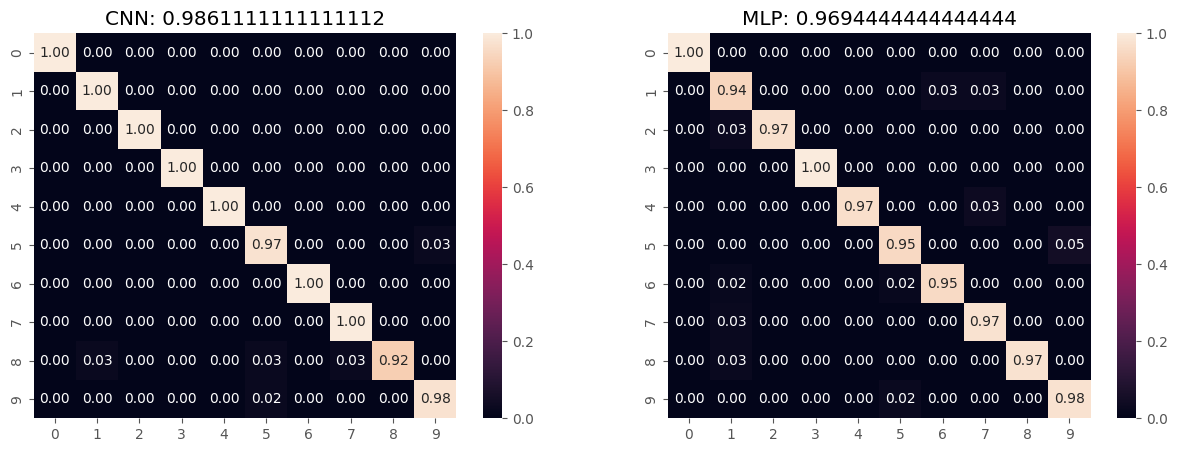

In [12]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(8,8,1),
                ) )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn2.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

12/12 [==============================] - 0s 2ms/step
CPU times: user 28.1 s, sys: 1.17 s, total: 29.3 s
Wall time: 29.4 s


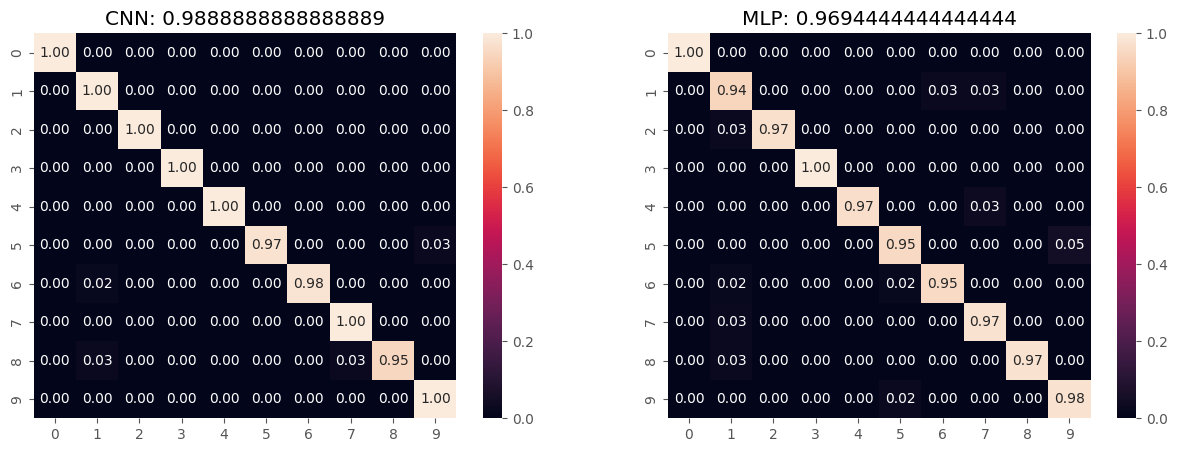

In [13]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn3.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

12/12 [==============================] - 0s 2ms/step
CPU times: user 30 s, sys: 1.21 s, total: 31.2 s
Wall time: 31.3 s


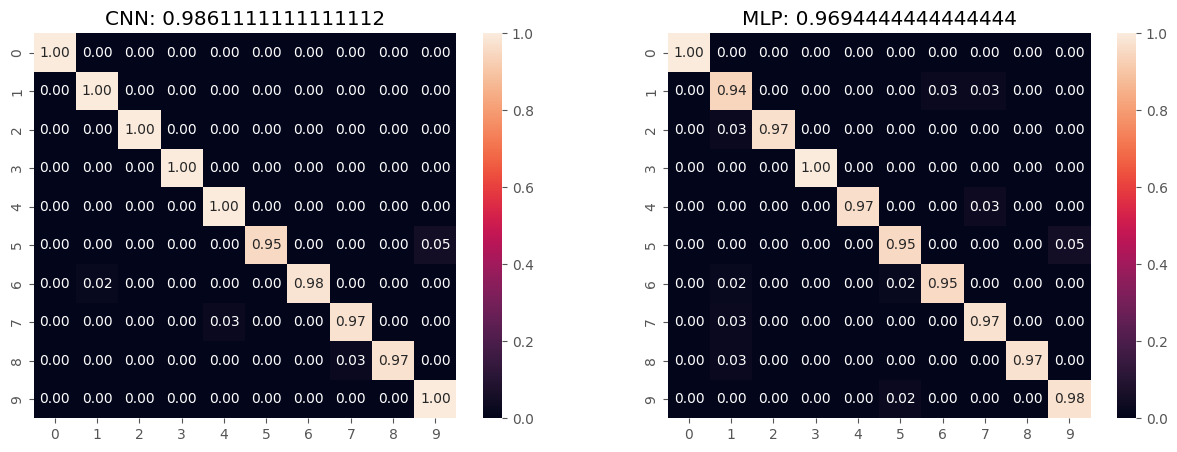

In [14]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()

num_filt_layers = [16, 32]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn4.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# Fashion MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: Fashion MNIST. We have already used this dataset in the past, where we got about 84% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [15]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
X_test, y_test = load_mnist('data/', kind='fashion_t10k')

X_train = X_train.reshape(X_train.shape[0],28,28,1)/255.0 - 0.5
X_test = X_test.reshape(X_test.shape[0],28,28,1)/255.0 - 0.5

print('X_train shape:', X_train.shape) 
print('X_test shape:', X_test.shape)

NUM_CLASSES = 10


# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [16]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Epoch 1/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5066 - accuracy: 0.8139
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3876 - accuracy: 0.8598
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3549 - accuracy: 0.8704
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3359 - accuracy: 0.8800
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3280 - accuracy: 0.8825
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3219 - accuracy: 0.8870
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3168 - accuracy: 0.8900
Epoch 8/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3167 - accuracy: 0.8890
Epoch 9/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3136 - accuracy: 0.8911
Epoch 10/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.312

313/313 [==============================] - 1s 2ms/step


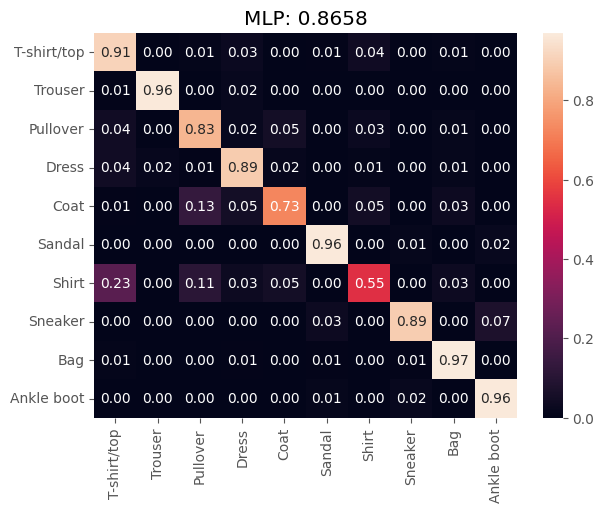

In [17]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
compare_mlp_cnn(None,mlp,X_test,y_test,labels)


Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0236 - accuracy: 0.8324 - val_loss: 0.0183 - val_accuracy: 0.8736
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0157 - accuracy: 0.8921 - val_loss: 0.0153 - val_accuracy: 0.8941
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0136 - accuracy: 0.9079 - val_loss: 0.0148 - val_accuracy: 0.8971
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0122 - accuracy: 0.9173 - val_loss: 0.0149 - val_accuracy: 0.8963
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0113 - accuracy: 0.9241 - val_loss: 0.0132 - val_accuracy: 0.9102
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0105 - accuracy: 0.9296 - val_loss: 0.0141 - val_accuracy: 0.9041
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0098 - accuracy: 0.9359 - val_loss: 0.0132 - val_accuracy

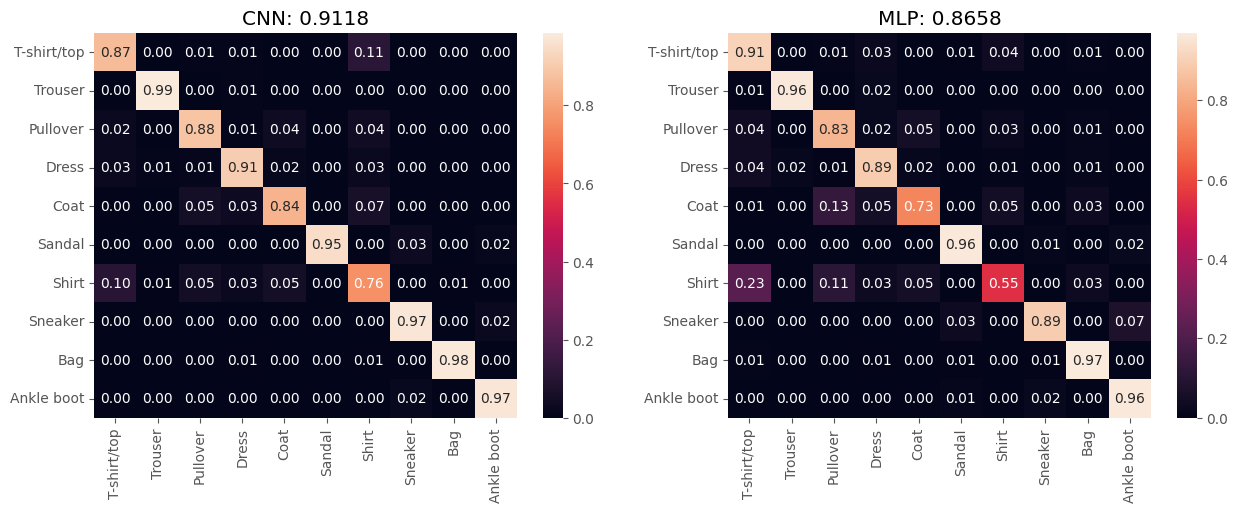

In [18]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same') )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           ) )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,
        validation_data=(X_test,y_test_ohe))

compare_mlp_cnn(cnn1,mlp,X_test,y_test,labels)

In [19]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2) ) )
    

# add one layer on flattened output
cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn2.add( Flatten() )
cnn2.add( Dense(1024, activation='relu') )
cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(X_train, y_train_ohe, 
        batch_size=64, epochs=30, 
        shuffle=True, verbose=1,
        validation_data=(X_test,y_test_ohe))



Epoch 1/30
938/938 [==============================] - 6s 6ms/step - loss: 0.4328 - accuracy: 0.8440 - val_loss: 0.3168 - val_accuracy: 0.8853
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2882 - accuracy: 0.8967 - val_loss: 0.2828 - val_accuracy: 0.8977
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2612 - accuracy: 0.9072 - val_loss: 0.2797 - val_accuracy: 0.9066
Epoch 4/30
938/938 [==============================] - 5s 6ms/step - loss: 0.2446 - accuracy: 0.9135 - val_loss: 0.2690 - val_accuracy: 0.9088
Epoch 5/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2406 - accuracy: 0.9164 - val_loss: 0.2666 - val_accuracy: 0.9097
Epoch 6/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2401 - accuracy: 0.9162 - val_loss: 0.2539 - val_accuracy: 0.9094
Epoch 7/30
938/938 [==============================] - 5s 5ms/step - loss: 0.2359 - accuracy: 0.9179 - val_loss: 0.2810 - val_accuracy: 0.9100
Epoch 

313/313 [==============================] - 1s 2ms/step


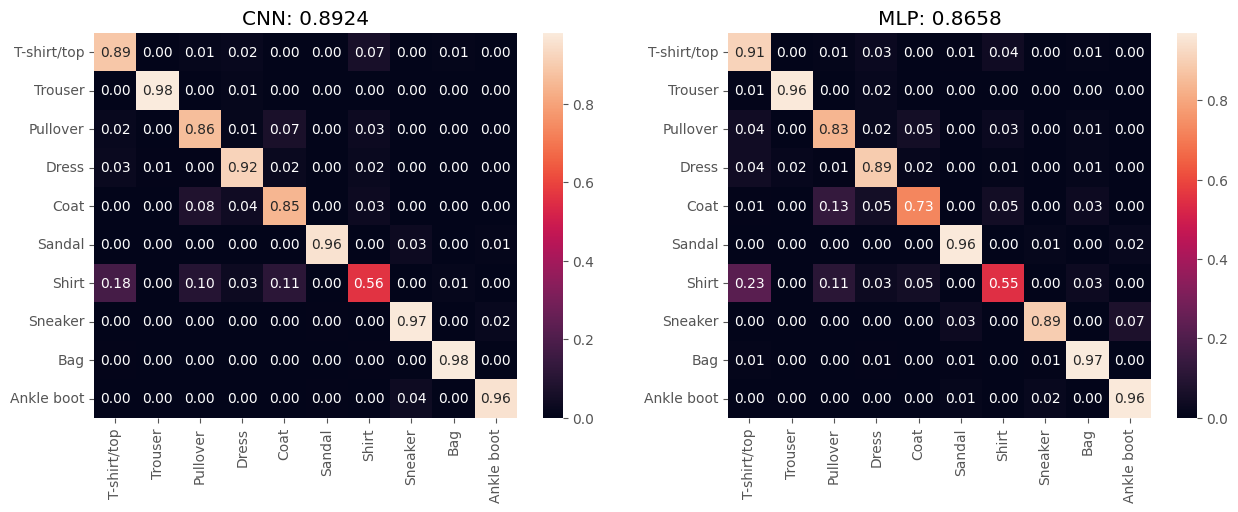

In [20]:
compare_mlp_cnn(cnn2,mlp,X_test,y_test,labels)

In [21]:
cnn2.evaluate(X_test,y_test_ohe,verbose=0)

[0.32245874404907227, 0.8924000263214111]

In [22]:
# want to save this model for later?
cnn2.save('large_data/mnist_cnn.h5')

313/313 [==============================] - 1s 2ms/step


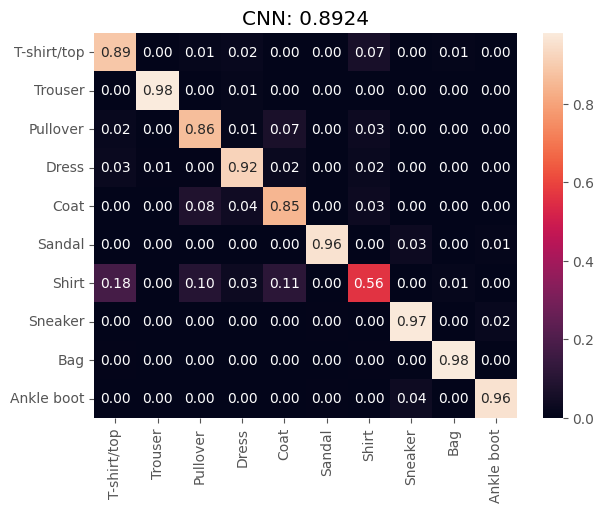

In [23]:
from tensorflow.keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.h5')
compare_mlp_cnn(cnn_mnist,None,X_test,y_test,labels)

In [ ]:
# How can we make this train better with a deep network with more filters??
